# CygnusX

In [1]:
import aplpy
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


INFO: Auto-setting vmin to -8.542e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.689e+02 [aplpy.core]


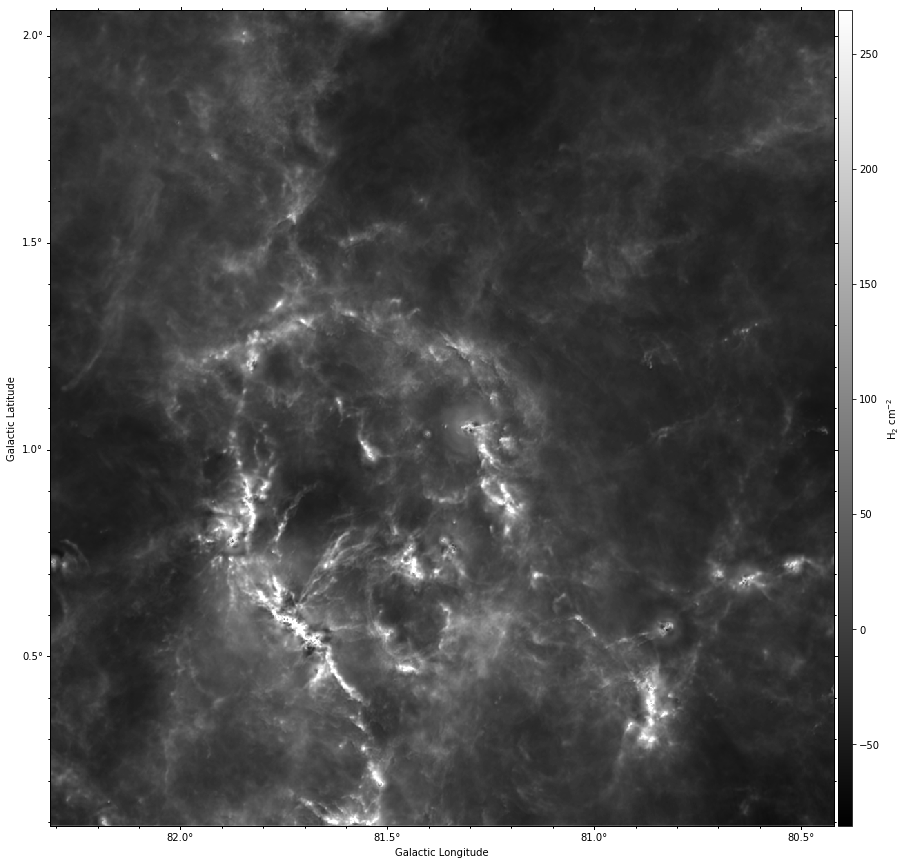

In [2]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_alt.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all, convention='calabretta')
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.5)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [4]:
from bokeh.plotting import figure as figbok
from bokeh.io import output_notebook
from bokeh.io import show as showbok
from bokeh.models import LogAxis, Range1d
output_notebook()

from astropy import wcs
from pywavan import fan_trans, apodize, padding, depad, powspec, gauss_beam
#from rebin import congrid

Loading BokehJS ...

In [5]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

In [14]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
imzm = im - np.mean(im)

#Apodization

tapper = apodize(nb,na,0.98)
imt = imzm *tapper
imr = padding(imt,1500,1500)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Beam Power spectrum
FWHM = 12. / (60.*reso)  #Beam size
#beam = gauss_beam(FWHM,im.shape[0],im.shape[1],FWHM=True)
beam = gauss_beam(FWHM,1500,1500,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation
#Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False)
#del Bwt,BS11a,Bq
#BS1an = BS1a / BS1a[3]

dFscl = 1400.*np.tan((1./(60.*tab_k))*(np.pi/180.))

#Plot Fourier power spectrum

xmin = 0.004
xmax = 10.

Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="Scale [arcmin]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log",x_range=(xmin, xmax), tools=Tools)
f.line(tab_k, spec_k/spec_beamn, legend='Fourier')

#Set a list of q
q=[]
#q[0:4]=[1.4]*5
#q[5:25]=[2.5]*20
q=[2.1]*25
print(q)

#Wavelet power spectrum
#wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True)
#wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=False, apodize= 0.98, arrdim = np.array([1500,1500]))

#dWscl = 1400.*np.tan((1./(60.*wav_k))*(np.pi/180.))
pcmin = 1400.*np.tan((xmin/60.)*(np.pi/180.))
pcmax = 1400.*np.tan((xmax/60.)*(np.pi/180.))

f.extra_x_ranges = {"parsec": Range1d(start=pcmin, end=pcmax)}
f.add_layout(LogAxis(x_range_name="parsec", axis_label="Scale [pc]"), 'above')

S1an = np.copy(S1a)

S1an[0,3:] = S1a[0,3:]/BS1an[3:]
S1an[1,3:] = S1a[1,3:]/BS1an[3:]
S1an[2,3:] = S1a[2,3:]/BS1an[3:]

f.diamond(wav_k, S1an[0,:], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_k, S1an[1,:], legend='Coherent',color='blue',line_width=5)
f.square(wav_k, S1an[2,:], legend='Gaussian',color='red',line_width=5)

#Power law fit
coef,cov = np.polyfit(np.log(wav_k[7:21]),np.log(S1an[2,7:21]),deg=1,cov=True)
yfit = np.exp(coef[1])*wav_k**coef[0]

coef2,cov2 = np.polyfit(np.log(wav_k[14:21]),np.log(S1an[1,14:21]),deg=1,cov=True)
yfit2 = np.exp(coef2[1])*wav_k**coef2[0]

print("Power law Gaussian = ", coef[0], np.sqrt(np.diag(cov)))
print("Power law coherent = ", coef2[0], np.sqrt(np.diag(cov2)))

f.line(wav_k, yfit, legend='Fit', line_dash='dashed')
f.line(wav_k, yfit2, line_dash='dashed')

f.legend.location = "top_right"

showbok(f)

[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1]
Power law Gaussian =  -3.2201332222885055 [0.02156092 0.03535417]
Power law coherent =  -2.7499012562957668 [0.02330734 0.01388449]
